# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [109]:
import os
import pandas as pd
import zipfile
import geopandas as  gpd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn
import datetime
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data Abstraction from sources

In [110]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once

!for ((y=94; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


--2017-12-13 16:10:31--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip”

100%[======================================>] 611,524     --.-K/s   in 0.05s   

2017-12-13 16:10:31 (11.6 MB/s) - “zbp94totals.zip” saved [611524/611524]

--2017-12-13 16:10:31--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp95totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625328 (611K) [application/zip]
Saving to: “zbp95totals.zip”

100%[======================================>] 625,328     --.-K/s   in 0.05s   

2017-12-13 16:10:31 (11

--2017-12-13 16:10:34--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: “zbp10totals.zip”

100%[======================================>] 797,534     --.-K/s   in 0.02s   

2017-12-13 16:10:34 (33.1 MB/s) - “zbp10totals.zip” saved [797534/797534]

--2017-12-13 16:10:34--  https://www2.census.gov/econ2011/CBP_CSV/zbp11totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 795390 (777K) [application/zip]
Saving to: “zbp11totals.zip”

100%[======================================>] 795,390     --.-K/s   in 0.08s   

2017-12-13 16:10:34 (8.94 MB/s) - “zbp11totals.zi

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [111]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!unzip application%2Fzip
os.system("mv " + "ZIP* "+ os.getenv("PUIDATA"))

--2017-12-13 16:10:35--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2017-12-13 16:10:35--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip.11”

100%[======================================>] 1,514,401   1.97M/s   in 0.7s    

2017-12-13 16:10:36 (1.97 MB/s) - “application%2Fzip.11” saved [1514401/1514401]

Archive:  application%2Fzip
  inflating: ZIP_CODE_040114.shx     
  inflat

0

In [112]:

zipNYC = gpd.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
zipNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [113]:
for i in range(94,100):
     os.system('mv zbp' + str(i) + 'totals.zip ' + os.getenv("PUIDATA"))


In [114]:
for i in range(0,15):
     os.system('mv zbp' + str(i) + 'totals.zip ' + os.getenv("PUIDATA"))

In [115]:
zipNYC.ZIPCODE = pd.to_numeric(zipNYC.ZIPCODE)

zipNYC = zipNYC[['ZIPCODE', 'geometry']]
zipNYC.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


## Data Cleaning

In [116]:
years = ['94', '95', '96','97', '98','99', '00','01', '02', '03','04','05','06', '07', '08','09', '10', '11', '12', '13', '14']
app_data1 = pd.DataFrame()

for i in years:
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + "/" 
                         + "zbp" + i + "totals.zip")
    app_data = pd.read_csv(zf.open('zbp'+ i 
                               +'totals.zip'.replace('.zip','.txt'))).assign(year=i)
    app_data.columns = [x.upper() for x in app_data.columns]

    app_data1 = app_data1.append(app_data)


In [117]:
app_data1 = app_data1[['ZIP','YEAR','EST']]

In [118]:
app_data1.shape

(828791, 3)

In [119]:
app_data1 = pd.pivot_table(app_data1, values='EST', index='ZIP', columns='YEAR')
app_data1.head()

YEAR,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
ZIP,,,,,,,,,,,,,,,,,,,,,
501,1.0,6.0,11.0,7.0,8.0,2.0,8.0,5.0,3.0,2.0,...,2.0,2.0,2.0,4.0,NaN,2.0,4.0,4.0,3.0,2.0
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,11.0,8.0,NaN,NaN
1001,493.0,490.0,490.0,505.0,500.0,509.0,509.0,503.0,477.0,458.0,...,436.0,453.0,439.0,458.0,439.0,439.0,433.0,457.0,444.0,469.0
1002,563.0,587.0,566.0,586.0,584.0,589.0,582.0,596.0,584.0,571.0,...,558.0,572.0,572.0,560.0,450.0,467.0,487.0,500.0,490.0,558.0
1003,13.0,13.0,15.0,16.0,15.0,12.0,12.0,16.0,17.0,16.0,...,16.0,15.0,15.0,18.0,10.0,10.0,13.0,15.0,14.0,13.0


In [120]:
app_data1.shape

(42671, 21)

In [121]:
app_data1.dropna(axis=0, inplace=True)

In [122]:
app_data1.head()
app_data1.shape

(35884, 21)

In [123]:
merge_data = zipNYC.merge(app_data1, right_index=True, left_on='ZIPCODE')
merge_data.set_index('ZIPCODE', inplace=True)

merge_data.shape

(243, 22)

In [124]:
merge_data=merge_data[['geometry']]
merge_data.shape

(243, 1)

In [90]:
merge_df = zipNYC.merge(app_data1, right_index=True, left_on='ZIPCODE')
merge_df.drop('geometry', axis=1, inplace=True)
merge_df.set_index('ZIPCODE', inplace=True)
merge_df.head()


,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,65.0,57.0,78.0,74.0,84.0,82.0,80.0,84.0,90.0,92.0,...,101.0,95.0,99.0,109.0,51.0,50.0,53.0,51.0,51.0,58.0
11213,477.0,493.0,546.0,569.0,570.0,556.0,565.0,556.0,592.0,621.0,...,674.0,726.0,755.0,772.0,406.0,420.0,433.0,456.0,476.0,473.0
11212,520.0,527.0,577.0,581.0,586.0,587.0,570.0,587.0,602.0,647.0,...,713.0,721.0,731.0,752.0,505.0,494.0,502.0,527.0,519.0,541.0
11225,417.0,422.0,479.0,488.0,492.0,491.0,499.0,514.0,520.0,543.0,...,597.0,623.0,673.0,696.0,381.0,387.0,388.0,410.0,416.0,409.0
11218,1161.0,1180.0,1228.0,1247.0,1295.0,1332.0,1331.0,1377.0,1397.0,1457.0,...,1523.0,1605.0,1687.0,1736.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0


In [125]:
df_samp = ((merge_df.T - merge_df.mean(axis=1)) / merge_df.std(axis=1)).T


In [126]:
df_samp.columns


Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '94', '95', '96', '97', '98', '99'],
      dtype='object')

In [127]:
merge_data = merge_data.merge(df_samp, right_index=True, left_index=True)


In [128]:
merge_data.columns

Index(['geometry', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10', '11', '12', '13', '14', '94', '95', '96', '97', '98', '99'],
      dtype='object')

In [129]:

merge_data.shape

(283, 22)

## Time Clustering Algorithms

In [130]:
CB = merge_data
CB_mean = CB.iloc[:,range(2,22)].mean(axis=1)
CB_std = CB.iloc[:,range(2,22)].std(axis=1)
CB.iloc[:,range(2,22)] = CB.iloc[:,range(2,22)].apply(lambda x: (x- CB_mean) / CB_std)

In [131]:
CB.head()
CB.dropna(axis=0, inplace=True)

## K-Means Clustering

In [132]:
mod_km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=500, tol=0.0001, 
                verbose=0, random_state=None).fit(CB.iloc[:,range(2,22)])

In [133]:

#set centers
centers = mod_km.cluster_centers_

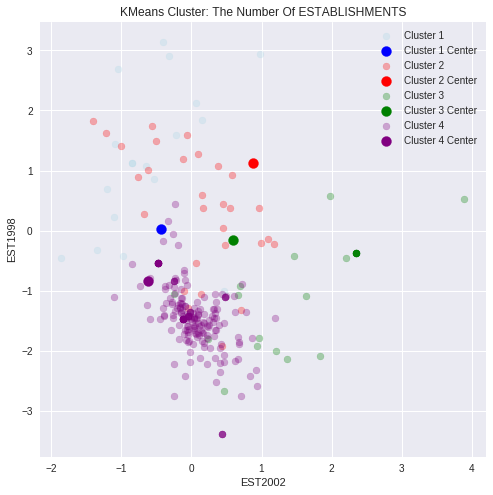

In [134]:
pl.figure(figsize=(8,8))
pl.scatter(CB[mod_km.labels_ == 0].iloc[:,5], CB[mod_km.labels_ == 0].iloc[:,16], \
           color='lightblue', alpha=0.3, label="Cluster 1")
pl.scatter(centers[0][0], centers[0][-1], marker='o', s=100, color='blue', label="Cluster 1 Center")

pl.scatter(CB[mod_km.labels_ == 1].iloc[:,5], CB[mod_km.labels_ == 1].iloc[:,16], \
           color='red', alpha=0.3, label="Cluster 2")
pl.scatter(centers[1][0], centers[1][-1], marker='o', s=100, color='red', label="Cluster 2 Center")

pl.scatter(CB[mod_km.labels_ == 2].iloc[:,5], CB[mod_km.labels_ == 2].iloc[:,16], \
           color='green', alpha=0.3, label="Cluster 3")
pl.scatter(centers[2][0], centers[2][-1], marker='o', s=100, color='green', label="Cluster 3 Center")

pl.scatter(CB[mod_km.labels_ == 3].iloc[:,5], CB[mod_km.labels_ == 3].iloc[:,16], \
           color='purple', alpha=0.3, label="Cluster 4")
pl.scatter(centers[3][0], centers[3][-1], marker='o', s=100, color='purple', label="Cluster 4 Center")

pl.xlabel("EST2002")
pl.ylabel("EST1998")
pl.title("KMeans Cluster: The Number Of ESTABLISHMENTS")
pl.legend(fontsize=10, loc='best')


### K-Means Clustring and Identifying the Centers

## DB Scan

In [135]:
mod_DBSCAN = DBSCAN(min_samples=4).fit(CB.iloc[:,range(2,21)])


In [136]:
unique(mod_DBSCAN.labels_)


array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

## Hierarchial Clustering Dendogram

In [137]:
Z = linkage(CB.iloc[:,range(2,21)], 'ward')

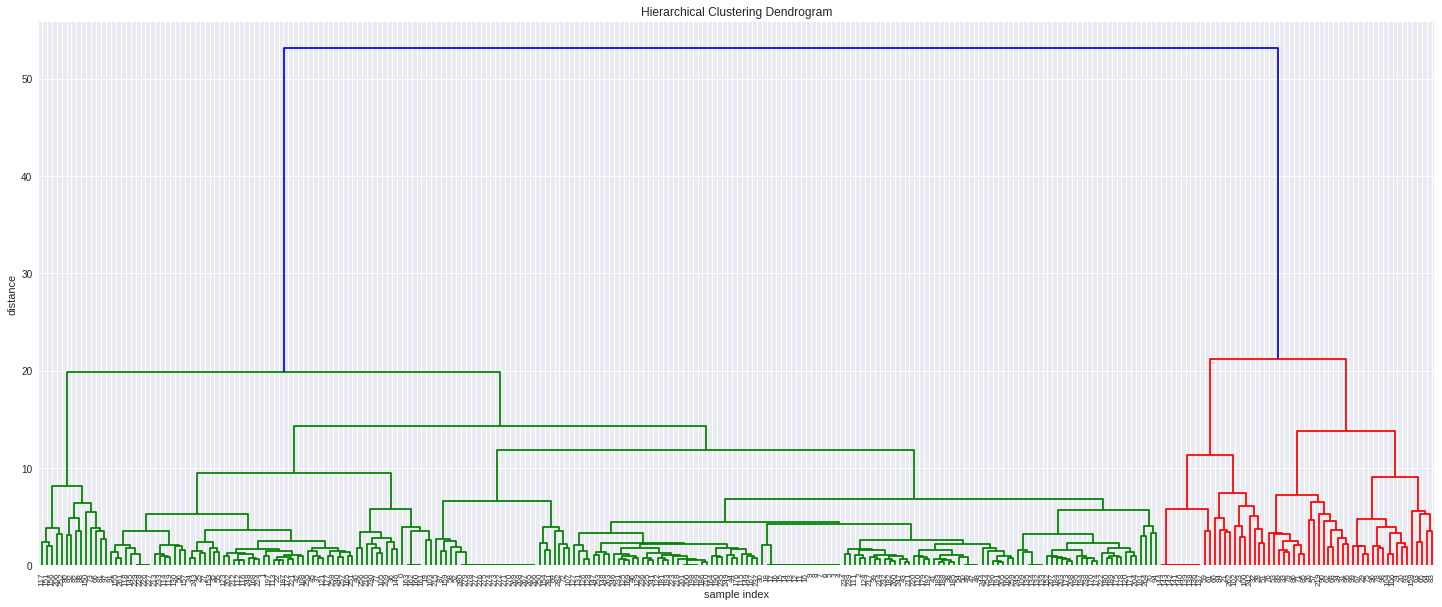

In [138]:

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
pl.show()

In [139]:
HC_label = fcluster(Z, 4, criterion='maxclust')


In [140]:
CB2 = CB.copy()
CB2['km'] = mod_km.labels_
CB2['DBSCAN'] = mod_DBSCAN.labels_
CB2['HC'] = HC_label
CB2['HC_'] = CB2.HC.replace([1,4],[4,1])

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


Text(0.5,1,'DBSCAN, k=5')

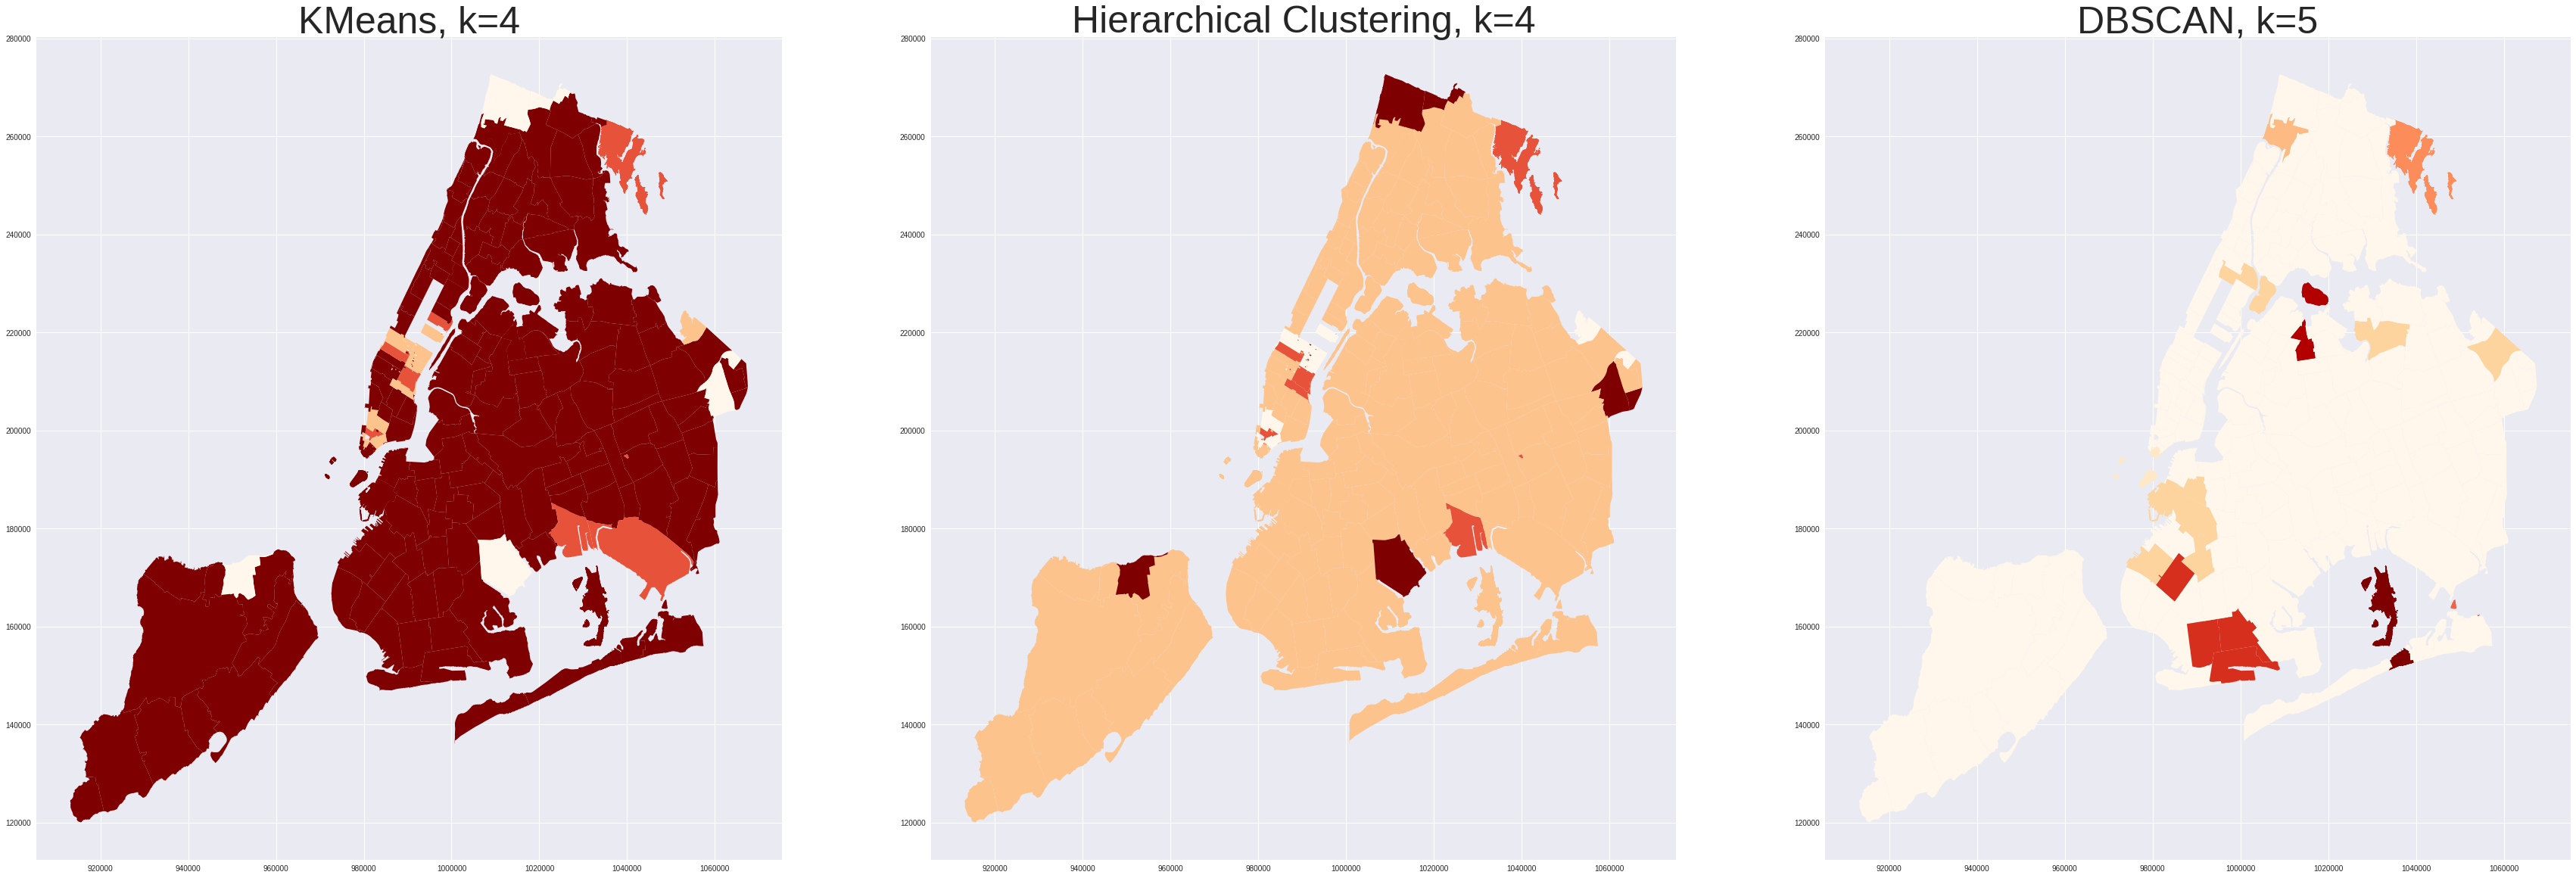

In [141]:
f, (ax1, ax2, ax3) = pl.subplots(1,3,figsize=(60,20))
CB2.plot(colormap='OrRd', column='km', ax=ax1, categorical=True, k=4)
ax1.set_title("KMeans, k=4", fontsize=50)
CB2.plot(colormap='OrRd', column='HC_', ax=ax2, categorical=True, k=4)
ax2.set_title("Hierarchical Clustering, k=4", fontsize=50)
CB2.plot(colormap='OrRd', column='DBSCAN', ax=ax3, categorical=True, k=5)
ax3.set_title("DBSCAN, k=5", fontsize=50)

## Different Clustering Results